In [36]:
initial_investment = 1000000
yearly_sale_percentage = 0.04
capital_gains_tax = 0.26
dividend_tax = 0.26
monthly_sale_percentage = yearly_sale_percentage / 12
ticker = 'VTI'

In [37]:
import pandas as pd

def load_source_data(prices_file, bigmac_file):
    # Stock prices
    ts = pd.read_csv(prices_file)
    ts = ts.sort_values(by="timestamp")
    ts = ts.reset_index()
    ts = ts.drop(columns="index")
    df = pd.DataFrame({
    "timestamp": ts["timestamp"],
    "price": ts["adjusted close"],
    "dividend yield": ts["dividend amount"] / ts["adjusted close"],
    })
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Big Mac index
    bigmac_pricedata = pd.read_csv(bigmac_file)
    country = "United States"
    bmprice = bigmac_pricedata[bigmac_pricedata.name == country][['date', 'dollar_price']]
    bmprice['date'] = pd.to_datetime(bmprice['date'])
    bmprice.rename(columns={"date": "timestamp", "dollar_price": "cpi"}, inplace=True)
    
    # Discard data that is not in the same time range for both datasets
    bmprice = bmprice[(bmprice['timestamp'] >= df['timestamp'].iloc[0]) & (bmprice['timestamp'] <= df['timestamp'].iloc[-1])]
    df = df[(df['timestamp'] >= bmprice['timestamp'].iloc[0]) & (df['timestamp'] <= bmprice['timestamp'].iloc[-1])]
    
    # Merge datasets
    df = pd.merge_asof(df, bmprice, on="timestamp")
    # Normalize CPI to 1 and stock price to 100
    df['cpi'] = df['cpi'].fillna(bmprice['cpi'].iloc[0])
    df['cpi'] = (df['cpi'] / df['cpi'].iloc[0]).round(3)
    df['price'] = (df['price'] / df['price'].iloc[0] * 100).round(3)
    return df

In [38]:
src = load_source_data(f"monthly_adjusted_{ticker}.csv", "bigmac.csv")
src

,timestamp,price,dividend yield,cpi
0,2002-04-30,100.000,0.000000,1.000
1,2002-05-31,98.570,0.000000,1.000
2,2002-06-28,91.774,0.008312,1.000
3,2002-07-31,84.120,0.000000,1.000
4,2002-08-30,84.763,0.000000,1.000
...,...,...,...,...
238,2022-02-28,628.439,0.000000,2.145
239,2022-03-31,648.955,0.003202,2.145
240,2022-04-29,589.694,0.000000,2.145
241,2022-05-31,588.212,0.000000,2.145


In [41]:
def transform_row(current_month: pd.Series, previous_month: pd.Series | None, first_month: pd.Series | None):
    month = current_month.copy()
    # Initialize new columns, avoid NaNs
    month['shares sold'] = 0
    month['capital gains'] = 0
    month['capital gains tax'] = 0
    month['shares purchased'] = 0

    month['shares'] = initial_investment / month['price'] if previous_month is None else previous_month['shares']
    month['cum capital losses'] = 0 if previous_month is None else previous_month['cum capital losses']
    month['cost basis rate'] = month['price'] if previous_month is None else previous_month['cost basis rate']
    month['portfolio value'] = month['shares'] * month['price']
    # Target income
    month['gross income'] = month['portfolio value'] * df['perc. sold']

    # Receive dividends
    month['gross dividend'] = month['shares'] * month['dividend yield'] * month['price']
    month['dividend tax'] = month['gross dividend'] * dividend_tax
    month['net dividend'] = month['gross dividend'] * (1 - dividend_tax)
    
    if month['gross income'] > month['net dividend']:
        # Dividends do not cover the entire target income
        # Use dividends to cover part of the target income
        remaining_target_income = month['gross income'] - month['net dividend']
        # Sell shares to cover the remaining target income
        month['shares sold'] = remaining_target_income / month['price']
        month['shares'] -= month['shares sold']
        month['capital gains'] = month['shares sold'] * (month['price'] - month['cost basis rate'])

        if month['capital gains'] < 0:
            month['cum capital losses'] -= month['capital gains']
            month['capital gains tax'] = 0
        elif month['cum capital losses'] > 0:
            net_capital_gains = month['capital gains'] - month['cum capital losses']
            if net_capital_gains < 0:
                month['cum capital losses'] = -net_capital_gains
                month['capital gains tax'] = 0
            else:
                month['capital gains tax'] = net_capital_gains * capital_gains_tax
                month['cum capital losses'] = 0
        else:
            month['capital gains tax'] = month['capital gains'] * capital_gains_tax

        month['net income'] = month['gross income'] - month['capital gains tax']
    else:
        # Dividends cover the entire target income
        # Buy shares with remaining dividends and update cost basis rate
        remaining_dividend_income = month['net dividend'] - month['gross income']
        month['shares purchased'] = remaining_dividend_income / month['price']
        month['cost basis rate'] = (month['shares'] * month['cost basis rate'] + month['shares purchased'] * month['price']) / (month['shares'] + month['shares purchased'])
        month['shares'] += month['shares purchased']
        month['net income'] = month['gross income']
    
    month['portfolio value'] = month['shares'] * month['price']
    month['infl. adj. portfolio value'] = month['portfolio value'] / month['cpi']
    month['infl. adj. net income'] = month['net income'] / month['cpi']

    first_month = first_month if first_month is not None else month
    month['infl. adj. portfolio growth'] = month['infl. adj. portfolio value'] / first_month['infl. adj. portfolio value']
    month['infl. adj. net income growth'] = month['infl. adj. net income'] / first_month['infl. adj. net income']
    return month

def process_strategy(df: pd.DataFrame):
    # Initialize an empty list to store new time series values
    new_time_series = []

    # Iterate over the DataFrame
    for i in range(len(df)):
        current_row = df.iloc[i]
        if len(new_time_series) == 0:
            previous_row = None
            first_row = None
        else:
            previous_row = new_time_series[-1]
            first_row = new_time_series[0]
        # Apply the transformation function
        new_row_value = transform_row(current_row, previous_row, first_row)
        new_time_series.append(new_row_value)

    # Create a new DataFrame for the new time series
    new_df = pd.DataFrame(new_time_series, index=df.index)
    return new_df

df = src.copy()
df['perc. sold'] = monthly_sale_percentage
df = process_strategy(df)
df

,timestamp,price,dividend yield,cpi,perc. sold,shares sold,capital gains,capital gains tax,shares purchased,shares,...,portfolio value,gross income,gross dividend,dividend tax,net dividend,net income,infl. adj. portfolio value,infl. adj. net income,infl. adj. portfolio growth,infl. adj. net income growth
0,2002-04-30,100.000,0.000000,1.000,0.003333,33.333333,0.000000,0.000000,0.000000,9966.666667,...,9.966667e+05,3333.333333,0.000000,0.000000,0.000000,3333.333333,9.966667e+05,3333.333333,1.000000,1.000000
1,2002-05-31,98.570,0.000000,1.000,0.003333,33.222222,-47.507778,0.000000,0.000000,9933.444444,...,9.791396e+05,3274.714444,0.000000,0.000000,0.000000,3274.714444,9.791396e+05,3274.714444,0.982414,0.982414
2,2002-06-28,91.774,0.008312,1.000,0.003333,0.000000,0.000000,0.000000,27.991219,9961.435664,...,9.142008e+05,3038.773101,7577.890874,1970.251627,5607.639247,3038.773101,9.142008e+05,3038.773101,0.917258,0.911632
3,2002-07-31,84.120,0.000000,1.000,0.003333,33.204786,-526.524475,0.000000,0.000000,9928.230878,...,8.351628e+05,2793.186560,0.000000,0.000000,0.000000,2793.186560,8.351628e+05,2793.186560,0.837956,0.837956
4,2002-08-30,84.763,0.000000,1.000,0.003333,33.094103,-503.489885,0.000000,0.000000,9895.136775,...,8.387415e+05,2805.155446,0.000000,0.000000,0.000000,2805.155446,8.387415e+05,2805.155446,0.841547,0.841547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,2022-02-28,628.439,0.000000,2.145,0.003333,23.394523,12183.209986,3167.634596,0.000000,6994.962250,...,4.395907e+06,14702.030372,0.000000,0.000000,0.000000,11534.395776,2.049374e+06,5377.340688,2.056228,1.613202
239,2022-03-31,648.955,0.003202,2.145,0.003333,6.742203,3649.472721,948.862907,0.000000,6988.220047,...,4.535040e+06,15131.385756,14535.134638,3779.135006,10755.999632,14182.522848,2.114238e+06,6611.898764,2.121309,1.983570
240,2022-04-29,589.694,0.000000,2.145,0.003333,23.294067,11228.366835,2919.375377,0.000000,6964.925980,...,4.107175e+06,13736.371441,0.000000,0.000000,0.000000,10816.996064,1.914767e+06,5042.888608,1.921171,1.512867
241,2022-05-31,588.212,0.000000,2.145,0.003333,23.216420,11156.532211,2900.698375,0.000000,6941.709560,...,4.083197e+06,13656.176802,0.000000,0.000000,0.000000,10755.478427,1.903588e+06,5014.209057,1.909955,1.504263


In [42]:
period_months = 12
dfs = [df[i:i+period_months] for i in range(0, df.shape[0], period_months)]
dfs = [df for df in dfs if df.shape[0] == period_months]

In [50]:
yearly = pd.DataFrame({
    "timestamp": [d["timestamp"].iloc[-1] for d in dfs],
    "price": [d["price"].iloc[-1] for d in dfs],
    "cpi": [d["cpi"].iloc[-1] for d in dfs],
    "shares": [d["shares"].iloc[-1] for d in dfs],
    "portfolio value": [d["portfolio value"].iloc[-1] for d in dfs],
    "infl. adj. portfolio value": [d["infl. adj. portfolio value"].iloc[-1] for d in dfs],
    "infl. adj. portfolio growth": [d["infl. adj. portfolio growth"].iloc[-1] for d in dfs],
    "dividend yield": [d['dividend yield'].sum() for d in dfs],
    "dividend tax": [d["dividend tax"].sum() for d in dfs],
    "net income": [d["net income"].sum() for d in dfs],
    "infl. adj. net income": [d["infl. adj. net income"].sum() for d in dfs],
    "gross income": [d["gross income"].sum() for d in dfs],
    "capital gains tax": [d["capital gains tax"].sum() * capital_gains_tax for d in dfs],
    "cost basis rate": [d["cost basis rate"].iloc[-1] for d in dfs],
})
yearly

,timestamp,price,cpi,shares,portfolio value,infl. adj. portfolio value,infl. adj. portfolio growth,dividend yield,dividend tax,net income,infl. adj. net income,gross income,capital gains tax,cost basis rate
0,2003-03-31,79.498,1.000,9931.452965,7.895306e+05,7.895306e+05,0.792171,0.044892,9451.530359,33942.543560,33942.543560,33942.543560,0.000000,99.634586
1,2004-03-31,110.978,1.047,9836.109284,1.091592e+06,1.042590e+06,1.046077,0.041129,10734.797093,39646.587148,37866.845413,39646.587148,0.000000,99.680310
2,2005-03-31,118.714,1.051,9805.411821,1.164040e+06,1.107554e+06,1.111259,0.050005,14792.004708,44561.750382,42412.314404,44579.271391,4.555462,100.092961
3,2006-03-31,136.407,1.136,9771.499334,1.332901e+06,1.173328e+06,1.177252,0.049530,16097.259093,47745.333375,43403.201693,49492.155639,454.173789,100.751618
4,2007-03-30,151.481,1.230,9731.807839,1.474184e+06,1.198524e+06,1.202532,0.048702,17641.037048,52614.308623,44173.996834,55368.507948,716.091825,101.720878
5,2008-03-31,142.828,1.277,9695.353798,1.384768e+06,1.084392e+06,1.088018,0.049135,19178.870622,56814.145967,44771.774049,60446.700716,944.464235,102.939897
6,2009-03-31,88.427,1.366,9540.826077,8.436666e+05,6.176183e+05,0.619684,0.032425,8915.832030,43904.072713,32597.368104,45367.549547,380.503977,102.972960
7,2010-03-31,135.802,1.460,9341.751031,1.268628e+06,8.689236e+05,0.871830,0.025626,7637.116513,43876.893020,30509.101048,44362.845032,126.347523,103.076860
8,2011-03-31,159.659,1.502,9142.611394,1.459700e+06,9.718377e+05,0.975088,0.025001,8392.841999,49284.360367,33033.180357,51571.899536,594.760184,103.256277
9,2012-03-30,171.205,1.621,8941.713472,1.530866e+06,9.443961e+05,0.947555,0.024093,8640.518531,53072.024748,34142.192707,56439.885550,875.643809,103.463132


In [52]:
yearly['infl. adj. monthly income'] = yearly['infl. adj. net income'] / period_months
yearly['infl. adj. monthly income change'] = yearly['infl. adj. monthly income'] / yearly['infl. adj. monthly income'].iloc[0]
yearly['tax/gross income ratio'] = (yearly['dividend tax'] + yearly['capital gains tax']) / yearly['gross income']
yearly

,timestamp,price,cpi,shares,portfolio value,infl. adj. portfolio value,infl. adj. portfolio growth,dividend yield,dividend tax,net income,infl. adj. net income,gross income,capital gains tax,cost basis rate,infl. adj. monthly income,infl. adj. monthly income change,tax/gross income ratio
0,2003-03-31,79.498,1.000,9931.452965,7.895306e+05,7.895306e+05,0.792171,0.044892,9451.530359,33942.543560,33942.543560,33942.543560,0.000000,99.634586,2828.545297,1.000000,0.278457
1,2004-03-31,110.978,1.047,9836.109284,1.091592e+06,1.042590e+06,1.046077,0.041129,10734.797093,39646.587148,37866.845413,39646.587148,0.000000,99.680310,3155.570451,1.115616,0.270762
2,2005-03-31,118.714,1.051,9805.411821,1.164040e+06,1.107554e+06,1.111259,0.050005,14792.004708,44561.750382,42412.314404,44579.271391,4.555462,100.092961,3534.359534,1.249533,0.331916
3,2006-03-31,136.407,1.136,9771.499334,1.332901e+06,1.173328e+06,1.177252,0.049530,16097.259093,47745.333375,43403.201693,49492.155639,454.173789,100.751618,3616.933474,1.278726,0.334425
4,2007-03-30,151.481,1.230,9731.807839,1.474184e+06,1.198524e+06,1.202532,0.048702,17641.037048,52614.308623,44173.996834,55368.507948,716.091825,101.720878,3681.166403,1.301434,0.331545
5,2008-03-31,142.828,1.277,9695.353798,1.384768e+06,1.084392e+06,1.088018,0.049135,19178.870622,56814.145967,44771.774049,60446.700716,944.464235,102.939897,3730.981171,1.319046,0.332910
6,2009-03-31,88.427,1.366,9540.826077,8.436666e+05,6.176183e+05,0.619684,0.032425,8915.832030,43904.072713,32597.368104,45367.549547,380.503977,102.972960,2716.447342,0.960369,0.204912
7,2010-03-31,135.802,1.460,9341.751031,1.268628e+06,8.689236e+05,0.871830,0.025626,7637.116513,43876.893020,30509.101048,44362.845032,126.347523,103.076860,2542.425087,0.898845,0.174999
8,2011-03-31,159.659,1.502,9142.611394,1.459700e+06,9.718377e+05,0.975088,0.025001,8392.841999,49284.360367,33033.180357,51571.899536,594.760184,103.256277,2752.765030,0.973209,0.174273
9,2012-03-30,171.205,1.621,8941.713472,1.530866e+06,9.443961e+05,0.947555,0.024093,8640.518531,53072.024748,34142.192707,56439.885550,875.643809,103.463132,2845.182726,1.005882,0.168607


Text(0.5, 1.0, 'Tax to gross income ratio')

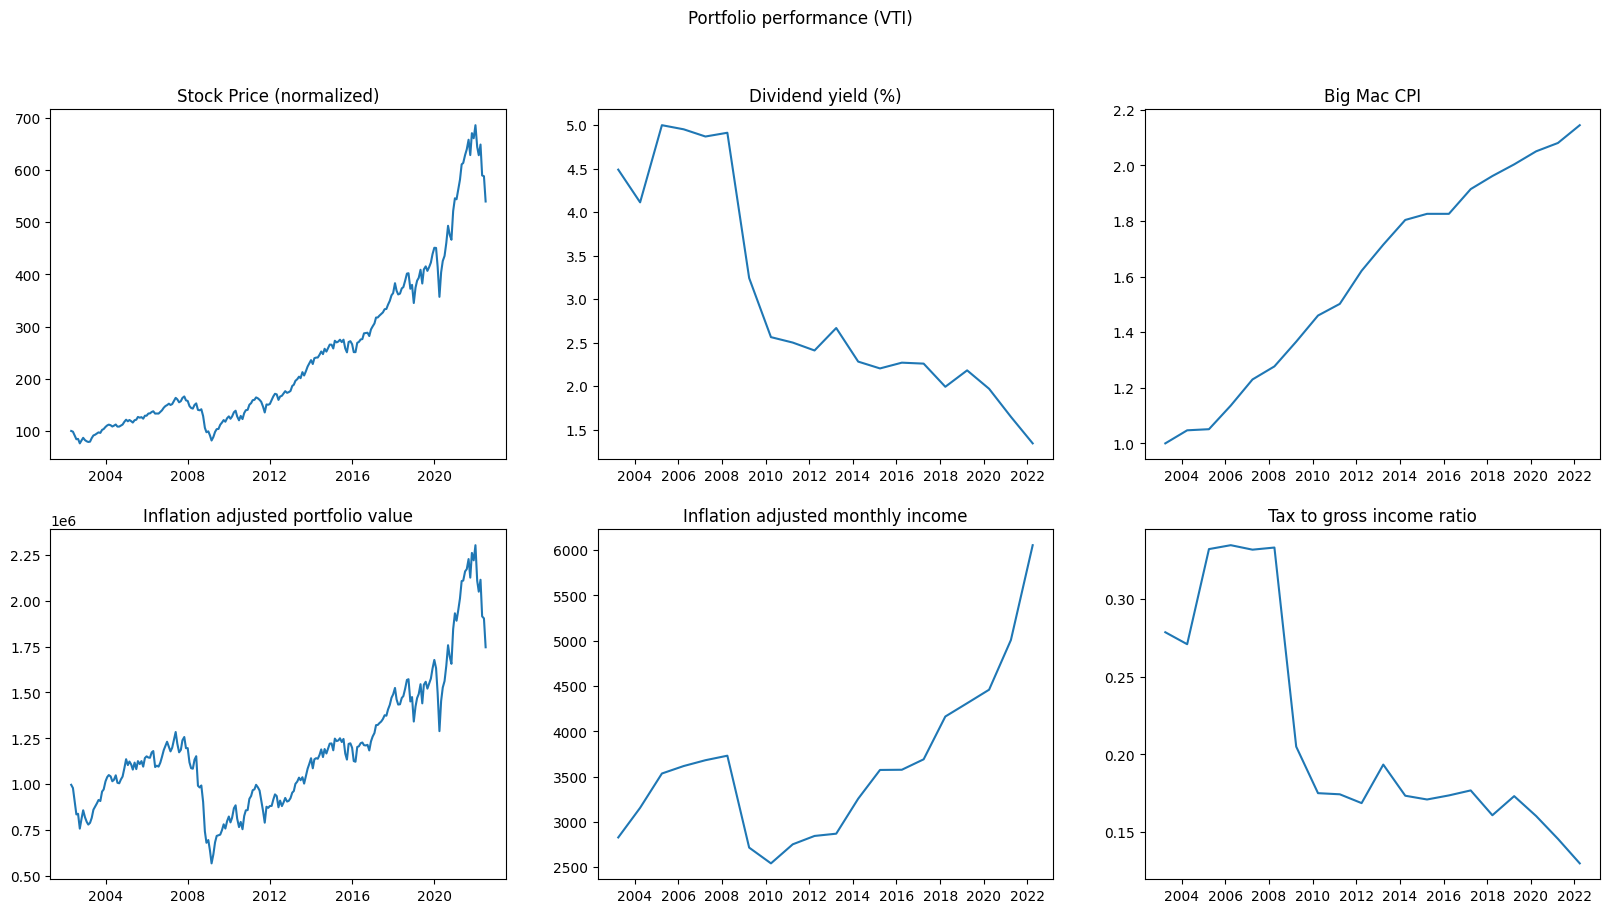

In [54]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))  # Adjust nrows and ncols based on the number of plots
fig.suptitle(f'Portfolio performance ({ticker})')
axs[0, 0].plot(df['timestamp'], df['price'])
axs[0, 0].set_title('Stock Price (normalized)')
axs[0, 1].plot(yearly['timestamp'], yearly['dividend yield'] * 100)
axs[0, 1].set_title('Dividend yield (%)')

axs[0, 2].plot(yearly['timestamp'], yearly['cpi'])
axs[0, 2].set_title('Big Mac CPI')

axs[1, 0].plot(df['timestamp'], df["infl. adj. portfolio value"])
axs[1, 0].set_title('Inflation adjusted portfolio value')

axs[1, 1].plot(yearly['timestamp'], yearly['infl. adj. monthly income'])
axs[1, 1].set_title('Inflation adjusted monthly income')

axs[1, 2].plot(yearly['timestamp'], yearly['tax/gross income ratio'])
axs[1, 2].set_title('Tax to gross income ratio')